In [1]:
from requests import get
from json import dumps
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MultipleLocator
import numpy as np
import datetime
import seaborn as sns
from tqdm import tqdm

In [2]:
# download api data
req = "https://api.coronavirus.data.gov.uk/v2/data?areaType=nation&areaCode=E92000001&metric=vaccinationsAgeDemographics&format=json"#&release=2021-07-06"
response = get(req, timeout=10)
if response.status_code >= 400:
    raise RuntimeError(f'Request failed: { response.text }')
response = response.json()

df = pd.DataFrame(response['body'])
df['dateTime'] = pd.to_datetime(df['date'])
df.sort_values(by=['dateTime'], inplace=True)
df.dropna(inplace=True)

x_dateTimes = sorted(list(set(df.dateTime.to_list())))
top_date = x_dateTimes[-1].strftime("%Y-%m-%d")
print(top_date)

2021-09-05


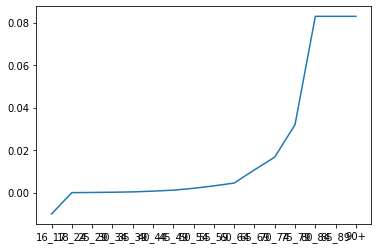

In [3]:
# unvaxed IFRs
# O’Driscoll et al.: Age-specific mortality and immunity patterns of SARS-CoV-2
# https://www.nature.com/articles/s41586-020-2918-0
# Supplementary information (table S3)
IFR = { 
    #"0_4":   0.003, # percent
    #"5_9":   0.001,
    #"10_14": 0.001,
    #"15_19": 0.003,
    #"20_24": 0.006, 
    "16_17": -1, # gets ignored by edge handler
    "18_24": 0.005, # interp
    "25_29": 0.013,
    "30_34": 0.024,
    "35_39": 0.040,
    "40_44": 0.075,
    "45_49": 0.121,
    "50_54": 0.207,
    "55_59": 0.323,
    "60_64": 0.456,
    "65_69": 1.075,
    "70_74": 1.674,
    "75_79": 3.203,
    "80_84": 8.292, 
    "85_89": 8.292, 
    "90+": 8.292, 
    #"80+": 8.292,
}
for k,v in IFR.items():
    IFR[k] = v/100

plt.clf()
plt.plot(IFR.keys(), IFR.values())
plt.show()    
    
# vax effects
# https://www.gov.uk/government/publications/covid-19-vaccine-surveillance-report
# table 2
# for simplicity, take the avg of the pfizer (0.02) and az (0.07) values
vaxMultiplier = 0.045

In [4]:
xs = x_dateTimes
ys_pop = {}
ys_vaxxed = {}
ys_deaths_vaxxed = {}
ys_deaths_unvaxxed = {}

itemList = df.vaccinationsAgeDemographics.to_list()

for item in itemList[-1]:
    l = item['age']
    ys_pop[l] = item['VaccineRegisterPopulationByVaccinationDate']
    ys_vaxxed[l] = []
    ys_deaths_vaxxed[l] = []
    ys_deaths_unvaxxed[l] = []

for items in itemList:
    for item in items:
        l = item['age']
        vaxxed = item['cumPeopleVaccinatedSecondDoseByVaccinationDate']
        ys_vaxxed[l].append(vaxxed)

        unvaxxed = ys_pop[l] - vaxxed
        ys_deaths_vaxxed[l].append(vaxxed * IFR[l] * vaxMultiplier)        
        ys_deaths_unvaxxed[l].append(unvaxxed * IFR[l])        
        
def handle_edges(ys):
    for key,y in ys.items():
        ys[key] = np.array(y)
    ys["80+"] = ys['80_84'] + ys['85_89'] + ys['90+']
    del ys['80_84']
    del ys['85_89']
    del ys['90+']
    del ys['16_17']

handle_edges(ys_pop)
handle_edges(ys_vaxxed)
handle_edges(ys_deaths_vaxxed)
handle_edges(ys_deaths_unvaxxed)

ys_deaths_vaxxed_leq = {}
ys_deaths_unvaxxed_leq = {}
ys_deaths_vaxxed_prop_leq = {}
ys_deaths_unvaxxed_prop_leq = {}

for key in ys_vaxxed.keys():
    ys_deaths_vaxxed_leq[key] = []
    ys_deaths_unvaxxed_leq[key] = []
    ys_deaths_vaxxed_prop_leq[key] = []
    ys_deaths_unvaxxed_prop_leq[key] = []

for i in range(len(xs)):
    total_deaths_vaxxed = 0
    total_deaths_unvaxxed = 0
    for key in ys_vaxxed.keys():
        total_deaths_vaxxed += ys_deaths_vaxxed[key][i]
        total_deaths_unvaxxed += ys_deaths_unvaxxed[key][i]
    deaths_vaxxed_leq = 0
    deaths_unvaxxed_leq = 0
    for key in ys_vaxxed.keys():
        deaths_vaxxed_leq += ys_deaths_vaxxed[key][i]
        deaths_unvaxxed_leq += ys_deaths_unvaxxed[key][i]
        ys_deaths_vaxxed_leq[key].append(deaths_vaxxed_leq)
        ys_deaths_vaxxed_prop_leq[key].append(deaths_vaxxed_leq/total_deaths_vaxxed)
        ys_deaths_unvaxxed_leq[key].append(deaths_unvaxxed_leq)
        ys_deaths_unvaxxed_prop_leq[key].append(deaths_unvaxxed_leq/total_deaths_unvaxxed)
    

/home/nic/venv/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in double_scalars


<Figure size 432x288 with 0 Axes>

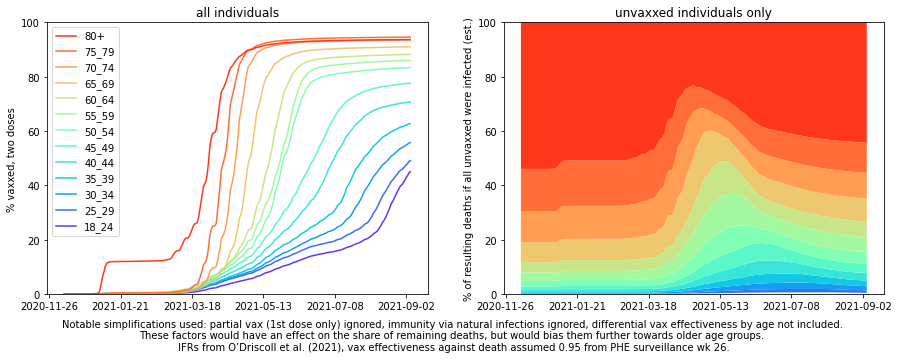

In [5]:
sns.set_palette("rainbow",len(ys_pop))

plt.clf()
fig, axes = plt.subplots(1,2, figsize=(15,5), gridspec_kw={'width_ratios':[1,1]})
fig.patch.set_facecolor('white')
ax0,ax1 = axes

for l,y in ys_vaxxed.items():
    ax0.plot(xs, 100*y/ys_pop[l], label=l)

handles, labels = ax0.get_legend_handles_labels()
ax0.legend(handles[::-1], labels[::-1], loc='upper left')

ax0.set_ylabel("% vaxxed, two doses")
ax0.set_ylim(0,100)
ax0.set_title("all individuals")

ax1.fill_between(xs,np.zeros(len(xs)), np.zeros(len(xs)), label="") # silently increment sns key
ys = ys_deaths_unvaxxed_prop_leq
for i in range(len(ys.keys())-1):
    l = list(ys.keys())[i]
    y1 = np.array(list(ys.values())[i])*100
    y2 = np.array(list(ys.values())[i+1])*100
    ax1.fill_between(xs, y1, y2, label=l)

ax1.set_ylabel("% of resulting deaths if all unvaxxed were infected (est.)")
ax1.set_ylim(0,100)
ax1.set_title("unvaxxed individuals only")

ax0.xaxis.set_major_locator(MultipleLocator(7*8)) 
ax1.xaxis.set_major_locator(MultipleLocator(7*8)) 

plt.figtext(0.5, -.03, "Notable simplifications used: partial vax (1st dose only) ignored, immunity via natural infections ignored, differential vax effectiveness by age not included.\nThese factors would have an effect on the share of remaining deaths, but would bias them further towards older age groups.\n IFRs from O’Driscoll et al. (2021), vax effectiveness against death assumed %.2f from PHE surveillance wk 26." % (1-vaxMultiplier), ha="center")

plt.savefig("vax_effects.png", dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()
